# Deconvolve Simulated Sin Example

Indices:
- c cell type
- g genes
- m samples
- k deformation polynomial degree

In [1]:
import torch
from time_deconv.time_deconv import *

## Parameter Configuration

In [2]:
device = torch.device("cuda:0")
dtype = torch.float32
dtype_np = np.float32

## Train Model

In [3]:
bulk_anndata_path = "/home/nbarkas/disk2/deconvolution_method/datasets/ebov/load_data_python/ebov_bulk.h5ad"
sc_anndata_path = "/home/nbarkas/disk2/deconvolution_method/datasets/ebov/load_data_python/ebov_sc.h5ad"

In [4]:
with open(bulk_anndata_path, 'rb') as fh:
    bulk_anndata  = anndata.read_h5ad(fh)
with open(sc_anndata_path, 'rb') as fh:
    sc_anndata = anndata.read_h5ad(fh)

In [5]:
# select samples only after or on tp 0
bulk_anndata = bulk_anndata[bulk_anndata.obs['dpi_time'] >= 0,]

In [6]:
ebov_dataset = DeconvolutionDataset(
    sc_anndata = sc_anndata,
    sc_celltype_col = "Subclustering_reduced",
    bulk_anndata = bulk_anndata,
    bulk_time_col = "dpi_time",
    dtype_np = dtype_np,
    dtype = dtype,
    device=device,
    feature_selection_method = 'overdispersed_bulk_and_high_sc' #'overdispersed_bulk'
)

/opt/conda/lib/python3.7/site-packages/sklearn/linear_model/_ridge.py:157: LinAlgWarning: Ill-conditioned matrix (rcond=3.1044e-10): result may not be accurate.
  return linalg.solve(A, Xy, sym_pos=True, overwrite_a=True).T


In [8]:
pseudo_time_reg_deconv = TimeRegularizedDeconvolution(
    dataset=ebov_dataset,
    polynomial_degree = 5,
    basis_functions = "polynomial",
    device=device,
    dtype=dtype)

In [9]:
pseudo_time_reg_deconv.fit_model(n_iters=5_001, verbose=True, log_frequency=1000)

[iteration: 0]   loss: 30370669.54
[iteration: 1000]   loss: 8828506.86
[iteration: 2000]   loss: 3696004.03
[iteration: 3000]   loss: 2148003.41
[iteration: 4000]   loss: 1558377.57
[iteration: 5000]   loss: 1285225.81


## Examine Outputs

<AxesSubplot:title={'center':'Losses'}, xlabel='iteration', ylabel='ELBO Loss'>

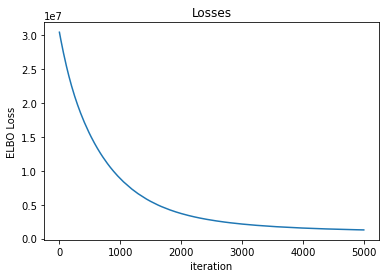

In [10]:
pseudo_time_reg_deconv.plot_loss()

In [11]:
pseudo_time_reg_deconv.calculate_composition_trajectories(n_intervals = 1000)

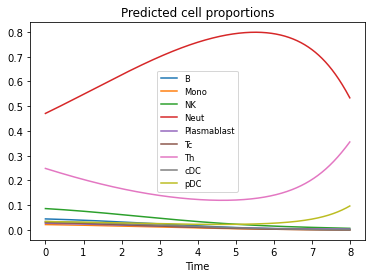

In [12]:
pseudo_time_reg_deconv.plot_composition_trajectories()

<AxesSubplot:xlabel='$\\phi_g$', ylabel='Counts'>

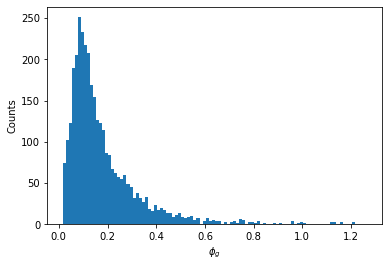

In [13]:
pseudo_time_reg_deconv.plot_phi_g_distribution()

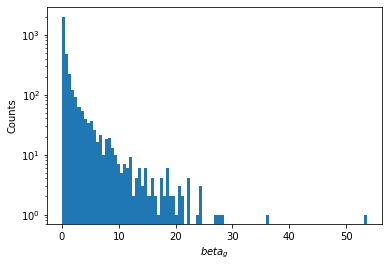

In [14]:
pseudo_time_reg_deconv.plot_beta_g_distribution()
matplotlib.pyplot.yscale('log')

# Synthetic Data

In [15]:
batch_dict = generate_batch(pseudo_time_reg_deconv.dataset, device, dtype)

## Evaluate Simulation 1 (100 samples; polynomial)

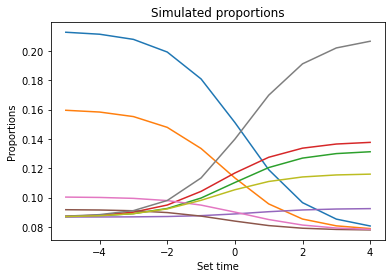

In [16]:
# Simulate and plot proportions
sim_res = simulate_with_sigmoid_proportions(num_samples=100, reference_deconvolution=pseudo_time_reg_deconv)
plot_simulated_proportions(sim_res)
matplotlib.pyplot.show()

In [17]:
simulated_bulk = generate_anndata_from_sim(sim_res, reference_deconvolution=pseudo_time_reg_deconv)

/opt/conda/lib/python3.7/site-packages/anndata/_core/anndata.py:120: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)


In [18]:
ebov_simulated_dataset = DeconvolutionDataset(
    sc_anndata = sc_anndata,
    sc_celltype_col = "Subclustering_reduced",
    bulk_anndata = simulated_bulk,
    bulk_time_col = "time",
    dtype_np = dtype_np,
    dtype = dtype,
    device = device,
    feature_selection_method = 'common' 
)

In [19]:
pseudo_time_reg_deconv_sim = TimeRegularizedDeconvolution(
    dataset=ebov_simulated_dataset,
    polynomial_degree = 20,
    basis_functions = "polynomial",
    device=device,
    dtype=dtype)

KeyboardInterrupt: 

In [23]:
pseudo_time_reg_deconv_sim.fit_model(n_iters=20_001, verbose=True, log_frequency=1000)

/mnt/disk2/nbarkas/deconvolution_method/temporal-rna-seq-deconvolution/time_deconv/time_deconv.py:242: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  "x_mg": torch.tensor(dataset.bulk_raw_gex_mg, device=device, dtype=dtype),


[iteration: 0]   loss: 2355438.59
[iteration: 1000]   loss: 1852086.37
[iteration: 2000]   loss: 1655786.86
[iteration: 3000]   loss: 1576399.12
[iteration: 4000]   loss: 1551489.18
[iteration: 5000]   loss: 1545156.40
[iteration: 6000]   loss: 1543837.70
[iteration: 7000]   loss: 1543530.14
[iteration: 8000]   loss: 1543364.95
[iteration: 9000]   loss: 1543219.80
[iteration: 10000]   loss: 1543091.58
[iteration: 11000]   loss: 1543045.97
[iteration: 12000]   loss: 1542975.09
[iteration: 13000]   loss: 1542908.13
[iteration: 14000]   loss: 1542869.92
[iteration: 15000]   loss: 1542809.81
[iteration: 16000]   loss: 1542775.35
[iteration: 17000]   loss: 1542742.28
[iteration: 18000]   loss: 1542729.64
[iteration: 19000]   loss: 1542766.14
[iteration: 20000]   loss: 1542702.95


<AxesSubplot:title={'center':'Losses'}, xlabel='iteration', ylabel='ELBO Loss'>

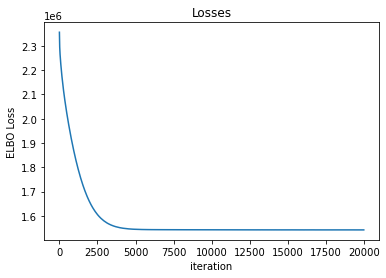

In [24]:
pseudo_time_reg_deconv_sim.plot_loss()

In [25]:
pseudo_time_reg_deconv_sim.calculate_composition_trajectories(n_intervals = 1000)

<AxesSubplot:title={'center':'Simulated proportions'}, xlabel='Set time', ylabel='Proportions'>

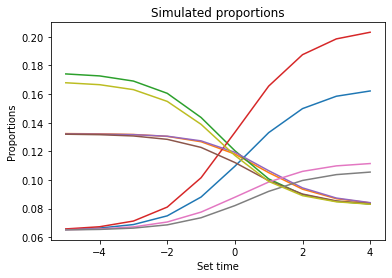

In [26]:
plot_simulated_proportions(sim_res)

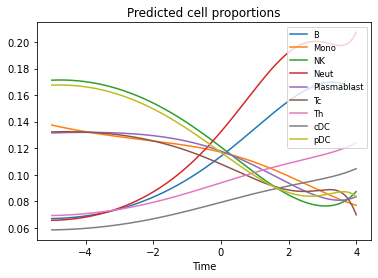

In [27]:
pseudo_time_reg_deconv_sim.plot_composition_trajectories()

In [28]:
calculate_prediction_error(sim_res, pseudo_time_reg_deconv_sim)

{'L1_error': tensor(0.3987),
 'L1_error_norm': tensor(0.0399),
 'L2_error': tensor(0.0566),
 'L2_error_norm': tensor(0.0057)}